<a href="https://colab.research.google.com/github/ej5959h/ej5959h/blob/main/3_5_selenium%5B%EB%8B%A4%EC%9D%8C%EC%B9%B4%ED%8E%98_%EC%85%80%EB%A0%88%EB%8B%88%EC%9B%80O%5D_%ED%95%99%EC%83%9D%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selenium 사용하여 크롤링 - 다음 카페 검색/ 페이지 이동/ 글 접속/ 내용 추출/ 저장까지

- note

In [ ]:
다음카페 홈 들어가기
https://top.cafe.daum.net/_c21_/home

돋보기 누르기 (이걸 눌러야 검색창이 나옴)
#daumSearch > fieldset > button

검색창 누르기
#q

---- 더보기

카페글 더보기
#mArticle > div.scafe_fulltxt.scafe_fulltxt2.search_article > div.scafe_btn > a
(위에 카페글 카테고리) #cSub > div.feature_ranking > div > div > ul > li:nth-child(3) > a

페이지
#mArticle > div > div.paging_scafe > span > a.btn_page.\#article\#result\#page\@1
#mArticle > div > div.paging_scafe > span > em - 현재 선택 (첫번째 선택한 페이지)

글
ul.list_scafe div.scafe_cont > strong > a

----- each 글 들어가서

글 제목
#primaryContent > div > div.bbs_read_tit > strong > span
#primaryContent > div > div.bbs_read_tit > strong

내용
#user_contents > p
#user_contents > div > a > div.og-text > p.og-title
#user_contents > p

댓글 박스 - 0인 경우가 많고, 서이추 안되어있으면 안보이는 듯
div.area_l #comment-btn
    댓글들 - 아이디,날짜 포함
    ul.list_comment div.comment_post


In [ ]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time
import re

# 크롬 드라이버 실행
driver = webdriver.Chrome("C:\dev_python\Webdriver\chromedriver.exe")

# 다음카페 홈 들어가기
driver.get('https://top.cafe.daum.net/_c21_/home')

## 검색
# 돋보기 누르기
search = driver.find_element_by_css_selector('#daumSearch > fieldset > button')
search.click()

# 검색창 클릭
search = driver.find_element_by_css_selector('#q')
search.click()

# 검색어 입력 / ENTER
keyword = input('검색어를 입력해랏: ')
keys = Keys()
search.send_keys(keyword)
search.send_keys(keys.ENTER)

# 검색 결과 나올 때까지 기둘
time.sleep(3)

###############

# '카페글 더보기' 클릭
more = driver.find_element_by_css_selector(
    '#cSub > div.feature_ranking > div > div > ul > li:nth-child(3) > a')
more.click()

# 최종 값 들어올 list 만들기
title_l = list()
content_l = list()
comment_l = list()

## 페이지 돌아야지
# 몇 페이지부터 몇 페이지 볼거야?
page_min = int(input('시작 페이지를 입력하세요: '))
page_max = int(input('마지막 페이지를 입력하세요: ')) + 1

# 범위 내에서 돌아요 - 처음 선택된 페이지는 em/ 나머지는 어쩌구저쩌구 page_num
for page_num in range(page_min,page_max):
    if page_num == page_min:
        driver.find_element_by_css_selector(
            '#mArticle > div > div.paging_scafe > span > em').click()
    else:
        driver.find_element_by_css_selector(
            '#mArticle > div > div.paging_scafe > span > a.btn_page.\#article\#result\#page\@{}'.format(str(page_num))).click()
    time.sleep(2)
#     한 page_num 내,
    # each 글을 클릭해야지
    post_lst = driver.find_elements_by_css_selector('ul.list_scafe div.scafe_cont > strong > a')
    for post in post_lst:
        post.click()
        time.sleep(2)
#     한 글 내,
        # driver를 방금 연 그 탭으로 돌려! 안하면 driver가 계속 '카페 더보기'에
        driver.switch_to.window(driver.window_handles[-1])
        print(driver.current_url)               # ---> progress 확인용

        # iframe 안으로 침투 - 이거 안하면 아래 제목/내용/댓글 다 안나옴
        driver.switch_to_frame("down")

#         이제부터 정적
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')

        # 글 제목
        title = soup.select_one(
            'strong.tit_info').text.strip()
        title = re.sub('[^0-9a-zA-Zㄱ-ㅣ가-힣 ]','',str(title))
        title_l.append(title)

        # 내용 - 문장마다 p로 구분되어있음 --> 댓글처럼 for문
        contents = soup.select(
            '#user_contents > p')
        content = ''
        for c in contents:
            content = content + ' ' + c.text.strip()
        content = re.sub('[^0-9a-zA-Zㄱ-ㅣ가-힣 ]','',str(content))
        content_l.append(content)

        # 댓글 박스 - 0인 경우가 많고, 서이추 안되어있으면 안보이는 듯
        comments = soup.select(
            'ul.list_comment div.comment_info div.box_post > p > span')
        comment = ''
        for c in comments:
            comment = comment + ' ' + c.text.strip()
        comment = re.sub('[^0-9a-zA-Zㄱ-ㅣ가-힣 ]','',str(comment))
        comment_l.append(comment)

        # 글 하나 닫기
        driver.close()
        # 이제 '카페글 더보기' 페이지로 돌아가서 다음 페이지 갈 준비하쟈~
        driver.switch_to.window(driver.window_handles[0])

cafe_df = pd.DataFrame({'제목':title_l,'본문':content_l,'댓글':comment_l})
cafe_df.to_csv('./다음카페_{}검색_{}-{}p.csv'.format(keyword, page_min, page_max-1),encoding='cp949')
driver.close()

검색어를 입력해랏: 샤넬
시작 페이지를 입력하세요: 1
마지막 페이지를 입력하세요: 10
http://cafe.daum.net/SoulDresser/FLTB/322046?q=%EC%83%A4%EB%84%AC


<ipython-input-69-9745b71a8333>:70: DeprecationWarning: use driver.switch_to.frame instead
  driver.switch_to_frame("down")


http://cafe.daum.net/dotax/D8UA/4613727?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/ok1221/9Zdf/2244920?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/subdued20club/ReHf/3022201?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/ok1221/9fQk/145766?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/Trucks040808/1psH/48195?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/baemilytory/91cd/233779?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/chanelunion/Ui2M/7?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/ju-narae/LlHM/49?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/moon8815/4QLE/7141?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/zoomin62/GNO8/510886?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/amazingpolo/J81C/972?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/itlookssogood/Exps/90?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/zoomin62/GN37/2447303?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/itlookssogood/IKWw/13?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/baemilytory/91cb/7732?q=%EC%83%A4%EB%84%AC
http://cafe.daum.net/itlookssogood/Expt/104?q=%EC%83

ElementClickInterceptedException: Message: element click intercepted: Element is not clickable at point (187, 522)
  (Session info: chrome=87.0.4280.141)


In [ ]:
cafe_df

,제목,본문,댓글
0,기타네이트판 남친이 제 립스틱 색이 창피하대요,소울드레서는 우리가 함께 만들어가는 소중한 공간입니다 댓글작성시타인에대한배려와책임...,베플 분 너무 호쾌한 느낌이긬ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 베플이 살렸긔 댄디 게슈탈...
1,드라마선배 그 립스틱 바르지 마요 드라마 방영 전부터 키갈함gif,바로 이 포스터 메이킹 영상이 어제 뜸 바로 키갈함 벌써 맛있 아니 재밌다ㅎㅎ참고...,잘 어울린다야근데 진짜 배우들 대단하다 나는 금사빠라 뭐 찍을 때마다 고백할 듯ㅠ...
2,눈물한방울언니 립스틱을 물어 뜯었던 말랭이가 댕댕이 별로 떠났습니다,출처 httpstwittercommallang100624s21 많은 여시들이...,말랭아 그곳에선 행복하렴 진짜 너무 속상하다ㅠㅠ 이제는 아프지말고 즐겁게 지내면서...
3,스크랩립스틱 짙게 바르고입술 건강이 자궁 건강화장품,립스틱 짙게 바르고입술 건강이 자궁 건강화장품hwp,
4,화장품립스틱,전부 미사용이고 운포가격입니다 에스티로더 에스티로더 퓨어컬러 러브 립스틱 250...,
5,궁금해요립스틱 여러분에 선택은,직원들에게 추석선물을 하려고 하는데 뭘할까 고민하다 아이디어가 생각났어요 추석은 ...,1번 립스틱은 취향 잘 모르면 선물 안하시는게 좋을듯요 1번 그냥 써요 1번 인데...
6,비건 화장품 나도 써볼까 핸드크림부터 립스틱 아이섀도우 브러쉬까지 다양해,,잘 보고 갑니다수고하셨습니다 감사합니다 감사합니다 감사합니다
7,공짜 립스틱ㅋ,다쓴 립스틱ㅋㅋ 매장가서 6개당 립스틱 새거 1개로 교환넝 좋아용공짜루 두개나엄마...,립스틱 엄청 발랐네요 ㅎㅎ립스틱을 발라 본적이 없다보니 저는 몰라도 되겠네요 ㅎㅎ...
8,립스틱 짖게 바르고임주리,,진숙씨가 부르믄 더 듣기 조흘꺼야뽈건 입술로 부를테니까진숙씨 고마워 금요일 아침 ...
9,여자와 남자가 평생먹는 립스틱의 양은,ㅎㅎㅎㅎㅎㅎㅎㅎ이야남자분들 잘 드시고 계시는거죠,어쩌면 그게 훨씬 좋겠군요 ㅎㅎㅎㅎ아 갑자기 딮키스의 향기가 제가 먹을꺼니까준비만...


# Word Cloud~~

In [ ]:
import pandas as pd # -----> 만약에 이어서 하면 './다음카페_{}검색_{}-{}p.csv'.format(keyword, page_min, page_max-1)
daumc_df = pd.read_csv("다음카페_샤넬검색_1-10p.csv",encoding='cp949')

In [ ]:
daumc_df

,Unnamed: 0,제목,본문,댓글
0,0,기타네이트판 남친이 제 립스틱 색이 창피하대요,소울드레서는 우리가 함께 만들어가는 소중한 공간입니다 댓글작성시타인에대한배려와책임...,베플 분 너무 호쾌한 느낌이긬ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 베플이 살렸긔 댄디 게슈탈...
1,1,드라마선배 그 립스틱 바르지 마요 드라마 방영 전부터 키갈함gif,바로 이 포스터 메이킹 영상이 어제 뜸 바로 키갈함 벌써 맛있 아니 재밌다ㅎㅎ참고...,잘 어울린다야근데 진짜 배우들 대단하다 나는 금사빠라 뭐 찍을 때마다 고백할 듯ㅠ...
2,2,눈물한방울언니 립스틱을 물어 뜯었던 말랭이가 댕댕이 별로 떠났습니다,출처 httpstwittercommallang100624s21 많은 여시들이...,말랭아 그곳에선 행복하렴 진짜 너무 속상하다ㅠㅠ 이제는 아프지말고 즐겁게 지내면서...
3,3,스크랩립스틱 짙게 바르고입술 건강이 자궁 건강화장품,립스틱 짙게 바르고입술 건강이 자궁 건강화장품hwp,NaN
4,4,화장품립스틱,전부 미사용이고 운포가격입니다 에스티로더 에스티로더 퓨어컬러 러브 립스틱 250...,NaN
5,5,궁금해요립스틱 여러분에 선택은,직원들에게 추석선물을 하려고 하는데 뭘할까 고민하다 아이디어가 생각났어요 추석은 ...,1번 립스틱은 취향 잘 모르면 선물 안하시는게 좋을듯요 1번 그냥 써요 1번 인데...
6,6,비건 화장품 나도 써볼까 핸드크림부터 립스틱 아이섀도우 브러쉬까지 다양해,,잘 보고 갑니다수고하셨습니다 감사합니다 감사합니다 감사합니다
7,7,공짜 립스틱ㅋ,다쓴 립스틱ㅋㅋ 매장가서 6개당 립스틱 새거 1개로 교환넝 좋아용공짜루 두개나엄마...,립스틱 엄청 발랐네요 ㅎㅎ립스틱을 발라 본적이 없다보니 저는 몰라도 되겠네요 ㅎㅎ...
8,8,립스틱 짖게 바르고임주리,,진숙씨가 부르믄 더 듣기 조흘꺼야뽈건 입술로 부를테니까진숙씨 고마워 금요일 아침 ...
9,9,여자와 남자가 평생먹는 립스틱의 양은,ㅎㅎㅎㅎㅎㅎㅎㅎ이야남자분들 잘 드시고 계시는거죠,어쩌면 그게 훨씬 좋겠군요 ㅎㅎㅎㅎ아 갑자기 딮키스의 향기가 제가 먹을꺼니까준비만...


## 모든 페이지/모든 글의 ['본문'] 내용만 모조리몽땅 모아 text_all에 모으기

In [ ]:
text_all = ' '.join(daumc_df['본문'])
text_all

' 소울드레서는 우리가 함께 만들어가는 소중한 공간입니다 댓글작성시타인에대한배려와책임을담아주세요 남친이 제 립스틱 색이 창피하데요너무너무 비참해서 터놓기도 챙피한 얘기에요ㅠㅠ남친이랑 사귄지 반년 넘었구요 어제 친구들 첨 소개시켜주는 자리였어영그런데 저를 태우러 와서 보자마자 표정이 안좋더니 제가 차에 타도 출발을 안하고 시큰둥 하더라구요솔직히 저 눈치없는 편이라 제가 잘못한거 뭔지도 모르겠고 그냥 에라 몰라 나중에 물어봐야지 하고 출발하자 했어요그런데 남친이 집에 들러서 옷 한번만 갈아입을까 하고 묻는거에요그때부터 기분 팍 상해서 왜 또 초치냐고 출발도 안하고 시비거냐며 제가 의사 표시 확실하게 하더니 깨갱 ㅋㅋ근데 약속 장소 도착하자 마자 또 실실 거리면서 이 패션 확정인거지 하고 놀리듯이 사람 꼽주는거에요솔직히 입구 들어서자마자 좀 기죽긴 했어요일반 스테이크 집은 아닌거 같아서요그냥 댄디한 멜빵 청바지에 어벙핏 아님 이쁜핏 블라우스에 명품 크로스백 매었고 위에는 패딩 입었어요퇴근하는데 너무 추워서 차마 코트는 오바였거등요겉옷 미스인건 인정해요 근데 솔직히 첨보는 자리에 너무 풀장착 하고 가기도 촌스럽고 좀 뭐라해야되지전 스탈 자체가 막 딱붙는 옷이나 나꾸몄다 과시하는 패션은 아니라 ㅠㅠ암튼간에 남친 친구들 오고 식사 시작하면서 마스크 벗었는데 남친이 또 뚱했어요그냥 오늘은 트집 잡고 싶은 날인가 하고 안좋은 감이 왔는데 역시나 다를까 집가는 길에 엄청 쪼잔대네요다른것도 아니곸ㅋㅋㅋ 제 립스틱이 민망하다네욬ㅋ웃으셔도 되요진심 너무 얼빠져서 되물었어요 정말 립스틱 색 때문에 사람 무안주고 꼽주는거냐고지가 립스틱을 사주면 몰라 사준적도 없으면서 절 인형마냥 지 멋대로 입히고 꾸미려는 심보가 넘 정뚝떨그래서 여자로서 꾸미는걸로 타박하니까 자존심도 상하고 뭐랄까 하루종일 꿀꿀아니 ㅡㅡ 남친 친구들이 제 뒷담 깟냐고 물어보니까 그건 또 아니래요근데 왜 절 챙피하다는 식으로 자존감을 깍는지나중엔 벽돌사이에 서면 보호색이라는둥 엄청 비꼬구요 홍대충 같아 보일수도 있다며 

## 한글 아닌 것들 없애기

In [ ]:
import re
text_all = re.sub('[^ㄱ-ㅣ가-힣 ]','',text_all)
text_all

' 소울드레서는 우리가 함께 만들어가는 소중한 공간입니다 댓글작성시타인에대한배려와책임을담아주세요 남친이 제 립스틱 색이 창피하데요너무너무 비참해서 터놓기도 챙피한 얘기에요ㅠㅠ남친이랑 사귄지 반년 넘었구요 어제 친구들 첨 소개시켜주는 자리였어영그런데 저를 태우러 와서 보자마자 표정이 안좋더니 제가 차에 타도 출발을 안하고 시큰둥 하더라구요솔직히 저 눈치없는 편이라 제가 잘못한거 뭔지도 모르겠고 그냥 에라 몰라 나중에 물어봐야지 하고 출발하자 했어요그런데 남친이 집에 들러서 옷 한번만 갈아입을까 하고 묻는거에요그때부터 기분 팍 상해서 왜 또 초치냐고 출발도 안하고 시비거냐며 제가 의사 표시 확실하게 하더니 깨갱 ㅋㅋ근데 약속 장소 도착하자 마자 또 실실 거리면서 이 패션 확정인거지 하고 놀리듯이 사람 꼽주는거에요솔직히 입구 들어서자마자 좀 기죽긴 했어요일반 스테이크 집은 아닌거 같아서요그냥 댄디한 멜빵 청바지에 어벙핏 아님 이쁜핏 블라우스에 명품 크로스백 매었고 위에는 패딩 입었어요퇴근하는데 너무 추워서 차마 코트는 오바였거등요겉옷 미스인건 인정해요 근데 솔직히 첨보는 자리에 너무 풀장착 하고 가기도 촌스럽고 좀 뭐라해야되지전 스탈 자체가 막 딱붙는 옷이나 나꾸몄다 과시하는 패션은 아니라 ㅠㅠ암튼간에 남친 친구들 오고 식사 시작하면서 마스크 벗었는데 남친이 또 뚱했어요그냥 오늘은 트집 잡고 싶은 날인가 하고 안좋은 감이 왔는데 역시나 다를까 집가는 길에 엄청 쪼잔대네요다른것도 아니곸ㅋㅋㅋ 제 립스틱이 민망하다네욬ㅋ웃으셔도 되요진심 너무 얼빠져서 되물었어요 정말 립스틱 색 때문에 사람 무안주고 꼽주는거냐고지가 립스틱을 사주면 몰라 사준적도 없으면서 절 인형마냥 지 멋대로 입히고 꾸미려는 심보가 넘 정뚝떨그래서 여자로서 꾸미는걸로 타박하니까 자존심도 상하고 뭐랄까 하루종일 꿀꿀아니 ㅡㅡ 남친 친구들이 제 뒷담 깟냐고 물어보니까 그건 또 아니래요근데 왜 절 챙피하다는 식으로 자존감을 깍는지나중엔 벽돌사이에 서면 보호색이라는둥 엄청 비꼬구요 홍대충 같아 보일수도 있다며 

## 형태소 분석

### 명사만 추출

In [ ]:
from konlpy.tag import Okt

okt = Okt()
noun_txt = okt.nouns(text_all)
noun_txt

['드레서',
 '우리',
 '공간',
 '댓글',
 '타인',
 '배려',
 '책임',
 '남친',
 '제',
 '립스틱',
 '색',
 '터',
 '기도',
 '챙피',
 '얘기',
 '남친',
 '반년',
 '어제',
 '친구',
 '소개',
 '데',
 '저',
 '표정',
 '제',
 '차',
 '타도',
 '출발',
 '안',
 '시큰둥',
 '저',
 '눈치',
 '편이',
 '제',
 '지도',
 '그냥',
 '에',
 '나중',
 '출발',
 '남친',
 '집',
 '옷',
 '한번',
 '그때',
 '기분',
 '팍',
 '상해',
 '왜',
 '또',
 '초',
 '출발',
 '안',
 '비거',
 '며',
 '제',
 '의사',
 '표시',
 '약속',
 '장소',
 '도착',
 '마자',
 '또',
 '실실',
 '거리',
 '면서',
 '이',
 '패션',
 '확정',
 '거지',
 '사람',
 '꼽',
 '입구',
 '좀',
 '일반',
 '스테이크',
 '그냥',
 '멜빵',
 '청바지',
 '어벙핏',
 '이쁜핏',
 '블라우스',
 '명품',
 '크로스',
 '위',
 '패딩',
 '퇴근',
 '차마',
 '코트',
 '바',
 '등',
 '겉옷',
 '미스',
 '건',
 '인정',
 '자리',
 '풀',
 '착',
 '가기',
 '좀',
 '스탈',
 '자체',
 '막',
 '옷',
 '나',
 '과시',
 '패션',
 '간',
 '남친',
 '친구',
 '식사',
 '시작',
 '마스크',
 '남친',
 '또',
 '그냥',
 '오늘',
 '트집',
 '잡고',
 '날인',
 '감',
 '역시',
 '길',
 '쪼',
 '잔대',
 '것',
 '아니곸',
 '제',
 '립스틱',
 '욬',
 '진심',
 '정말',
 '립스틱',
 '색',
 '때문',
 '사람',
 '무안',
 '꼽',
 '고지',
 '립스틱',
 '사주면',
 '적도',
 '절',
 '인형',
 '마냥',
 '멋대로',
 '심보',
 '정뚝',
 '여자'

### 명사 빈도수 측정

In [ ]:
from collections import Counter     # jdk에서 제공하는 라이브러리
count = Counter(noun_txt) # Counter()카운트 하는 함수
count

Counter({'드레서': 1,
         '우리': 6,
         '공간': 1,
         '댓글': 1,
         '타인': 1,
         '배려': 1,
         '책임': 1,
         '남친': 6,
         '제': 7,
         '립스틱': 85,
         '색': 5,
         '터': 1,
         '기도': 2,
         '챙피': 1,
         '얘기': 3,
         '반년': 1,
         '어제': 2,
         '친구': 8,
         '소개': 1,
         '데': 1,
         '저': 6,
         '표정': 1,
         '차': 1,
         '타도': 1,
         '출발': 3,
         '안': 10,
         '시큰둥': 1,
         '눈치': 2,
         '편이': 1,
         '지도': 1,
         '그냥': 5,
         '에': 1,
         '나중': 2,
         '집': 2,
         '옷': 2,
         '한번': 1,
         '그때': 1,
         '기분': 1,
         '팍': 1,
         '상해': 1,
         '왜': 4,
         '또': 6,
         '초': 1,
         '비거': 1,
         '며': 1,
         '의사': 2,
         '표시': 2,
         '약속': 1,
         '장소': 1,
         '도착': 1,
         '마자': 1,
         '실실': 1,
         '거리': 1,
         '면서': 1,
         '이': 7,
         '패션': 2,
   

In [ ]:
rank_text = count.most_common()
# Counter함수에서 dict형태로 뽑아준 빈도수를
# 내림차순 정렬, list(tuple)로 뽑음

In [ ]:
rank_text

[('파이썬', 34),
 ('코딩', 15),
 ('데이터', 15),
 ('언어', 13),
 ('과정', 11),
 ('기초', 10),
 ('사용', 10),
 ('값', 10),
 ('코드', 9),
 ('변수', 9),
 ('엔트로피', 9),
 ('학원', 8),
 ('입문', 7),
 ('분기', 7),
 ('가장', 6),
 ('모두', 6),
 ('기본', 6),
 ('직접', 6),
 ('업무', 6),
 ('곳', 6),
 ('진행', 6),
 ('실행', 6),
 ('입력', 6),
 ('작업', 6),
 ('이', 6),
 ('다음', 6),
 ('계산', 6),
 ('반환', 6),
 ('워드', 6),
 ('클라우드', 6),
 ('교육', 5),
 ('위', 5),
 ('때문', 5),
 ('점', 5),
 ('아이티', 5),
 ('뱅크', 5),
 ('를', 5),
 ('의', 5),
 ('기준', 5),
 ('서브', 5),
 ('트리', 5),
 ('자바스크립트', 5),
 ('정보', 4),
 ('시작', 4),
 ('전', 4),
 ('사람', 4),
 ('경우', 4),
 ('개월', 4),
 ('학생', 4),
 ('비', 4),
 ('아래', 4),
 ('이미지', 4),
 ('모듈', 4),
 ('하나', 4),
 ('예측', 4),
 ('클래스', 4),
 ('파일', 4),
 ('스크립트', 4),
 ('트랜스', 4),
 ('공부', 4),
 ('때', 3),
 ('아두이노', 3),
 ('정도', 3),
 ('속', 3),
 ('분야', 3),
 ('프로그램', 3),
 ('본인', 3),
 ('재', 3),
 ('별로', 3),
 ('미래', 3),
 ('문의', 3),
 ('클릭', 3),
 ('접속', 3),
 ('모든', 3),
 ('객체', 3),
 ('의사결정', 3),
 ('나무', 3),
 ('대한', 3),
 ('학습', 3),
 ('영역', 3),
 ('레이블', 3),
 ('비율', 3

In [ ]:
len(rank_text)

728

### 빈도수 높은 것들만 추출

In [ ]:
up_rank = []

for keyword, num in rank_text: # ('분기', 7) 이렇게 tuple로 나왔잖앙
    if num > 1: # 10번 이상 나온 keyword일 경우에만 up_rank에 붙임
        up_rank.append((keyword,num)) # tuple 형태로
    else:
        print(keyword,num) # 쩌리들은 그냥 print만 해줘 보기만 하게

드레서 1
공간 1
댓글 1
타인 1
배려 1
책임 1
터 1
챙피 1
반년 1
소개 1
데 1
표정 1
차 1
타도 1
시큰둥 1
편이 1
지도 1
에 1
한번 1
그때 1
기분 1
팍 1
상해 1
초 1
비거 1
며 1
약속 1
장소 1
도착 1
마자 1
실실 1
거리 1
면서 1
확정 1
거지 1
입구 1
일반 1
스테이크 1
멜빵 1
청바지 1
어벙핏 1
이쁜핏 1
블라우스 1
명품 1
크로스 1
패딩 1
퇴근 1
차마 1
코트 1
바 1
겉옷 1
미스 1
인정 1
풀 1
착 1
가기 1
스탈 1
자체 1
막 1
과시 1
식사 1
마스크 1
트집 1
잡고 1
날인 1
역시 1
길 1
쪼 1
잔대 1
아니곸 1
욬 1
진심 1
무안 1
고지 1
사주면 1
적도 1
마냥 1
멋대로 1
심보 1
정뚝 1
로서 1
는걸 1
박하 1
자존심 1
상하 1
종일 1
꿀꿀 1
담 1
깟냐 1
챙 1
식 1
자존감 1
사이 1
서면 1
보호색 1
둥 1
홍대 1
충 1
남 1
유행 1
그먕 1
무난 1
기 1
바라지 1
대요 1
자 1
여기 1
비비 1
제일 1
인기 1
시선 1
의심 1
정도 1
여러분 1
입맛 1
모멸 1
타당 1
포스터 1
메이킹 1
뜸 1
프로필 1
여주 1
첫방송 1
에드 1
라마 1
설명 1
댕댕 1
자궁 1
전부 1
미사 1
용이 1
운포 1
레디 1
컬 1
시크 1
포피 1
밍 1
스머지 1
세미 1
매트 1
직원 1
고민 1
아이디어 1
고생 1
가요 1
내기 1
답글 1
지인 1
둘 1
넝 1
공짜 1
루 1
스무 1
살 1
에나 1
대가 1
삶 1
어쩌면 1
대변 1
가가 1
지지 1
못 1
이자 1
로망 1
박지현 1
바람 1
분다 1
다중 1
어머니 1
아내 1
공통점 1
촌티 1
빈티 1
시절 1
보조개 1
뽕 1
컷팅 1
식구 1
요가 1
이규한 1
왕빛나 1
하윤 1
경 1
이동 1
박소 1
최정원 1
캐릭터 1
맛집 1
연애 1
세포 1
촘촘 1
에피소드 1
밀도 1
재미 1
선사 1
앞서 1
오후 1
유튜브 1
채널 1


In [ ]:
len(up_rank)

12

### 의미 없는 단어 제거 - 한글자(좀/이..)

In [ ]:
up_rank

[('립스틱', 85),
 ('칸토', 60),
 ('유라', 28),
 ('입술', 22),
 ('엄마', 22),
 ('말', 20),
 ('그', 16),
 ('고양이', 15),
 ('하나', 12),
 ('에스티', 11),
 ('로더', 11),
 ('대나무', 11),
 ('안', 10),
 ('것', 10),
 ('생쥐', 10),
 ('분홍', 10),
 ('숲', 9),
 ('사용', 9),
 ('천원', 9),
 ('친구', 8),
 ('사람', 8),
 ('사랑', 8),
 ('다시', 8),
 ('발라', 8),
 ('그대', 8),
 ('제품', 8),
 ('제', 7),
 ('이', 7),
 ('원', 7),
 ('모습', 7),
 ('밤', 7),
 ('보고', 7),
 ('만원', 7),
 ('기한', 7),
 ('우리', 6),
 ('남친', 6),
 ('저', 6),
 ('또', 6),
 ('시작', 6),
 ('정말', 6),
 ('이제', 6),
 ('남자', 6),
 ('시', 6),
 ('개', 6),
 ('선배', 6),
 ('다짐', 6),
 ('택비', 6),
 ('색', 5),
 ('그냥', 5),
 ('위', 5),
 ('나', 5),
 ('오늘', 5),
 ('인형', 5),
 ('여자', 5),
 ('색상', 5),
 ('번', 5),
 ('월화드라마', 5),
 ('선택', 5),
 ('호', 5),
 ('눈', 5),
 ('향', 5),
 ('얼굴', 5),
 ('방울', 5),
 ('왜', 4),
 ('건', 4),
 ('때문', 4),
 ('뭐', 4),
 ('거', 4),
 ('교환', 4),
 ('치마', 4),
 ('내', 4),
 ('베란다', 4),
 ('창문', 4),
 ('달라', 4),
 ('분홍립스틱', 4),
 ('위해', 4),
 ('가슴', 4),
 ('욱', 4),
 ('눈물', 4),
 ('끌', 4),
 ('라르', 4),
 ('분', 4),
 ('더', 4),
 ('추가'

In [ ]:
for keyword,num in up_rank:
    if len(keyword) == 1:
#         print(keyword,num)
        print('up_rank.remove(("{}", {}))'.format(keyword,num))

In [ ]:
# 위에 결과 복붙해서 수동 삭제

In [ ]:
up_rank.remove(('삭제하고싶은단어', 몇개인지))

In [ ]:
up_rank.remove(('삭제하고싶은단어', 몇개인지))

- 딕셔너리 형태로 바꿔줘야 아래에서 process가능

In [ ]:
dict_rank = dict(up_rank)
dict_rank

{'립스틱': 85,
 '칸토': 60,
 '유라': 28,
 '입술': 22,
 '엄마': 22,
 '말': 20,
 '그': 16,
 '고양이': 15,
 '하나': 12,
 '에스티': 11,
 '로더': 11,
 '대나무': 11,
 '안': 10,
 '것': 10,
 '생쥐': 10,
 '분홍': 10,
 '숲': 9,
 '사용': 9,
 '천원': 9,
 '친구': 8,
 '사람': 8,
 '사랑': 8,
 '다시': 8,
 '발라': 8,
 '그대': 8,
 '제품': 8,
 '제': 7,
 '이': 7,
 '원': 7,
 '모습': 7,
 '밤': 7,
 '보고': 7,
 '만원': 7,
 '기한': 7,
 '우리': 6,
 '남친': 6,
 '저': 6,
 '또': 6,
 '시작': 6,
 '정말': 6,
 '이제': 6,
 '남자': 6,
 '시': 6,
 '개': 6,
 '선배': 6,
 '다짐': 6,
 '택비': 6,
 '색': 5,
 '그냥': 5,
 '위': 5,
 '나': 5,
 '오늘': 5,
 '인형': 5,
 '여자': 5,
 '색상': 5,
 '번': 5,
 '월화드라마': 5,
 '선택': 5,
 '호': 5,
 '눈': 5,
 '향': 5,
 '얼굴': 5,
 '방울': 5,
 '왜': 4,
 '건': 4,
 '때문': 4,
 '뭐': 4,
 '거': 4,
 '교환': 4,
 '치마': 4,
 '내': 4,
 '베란다': 4,
 '창문': 4,
 '달라': 4,
 '분홍립스틱': 4,
 '위해': 4,
 '가슴': 4,
 '욱': 4,
 '눈물': 4,
 '끌': 4,
 '라르': 4,
 '분': 4,
 '더': 4,
 '추가': 4,
 '찜': 4,
 '얘기': 3,
 '출발': 3,
 '등': 3,
 '머리': 3,
 '채': 3,
 '자기': 3,
 '컬러': 3,
 '키': 3,
 '함': 3,
 '드라마': 3,
 '월': 3,
 '일': 3,
 '글': 3,
 '가격': 3,
 '선물': 3,
 '뭘': 3,


#### stopwords = [리스트로 콕집어서 없앨수도 있다]

### 워드클라우드 만들기

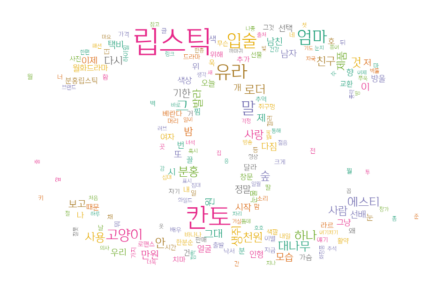

In [ ]:
# !pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
img_path = './chanel.png'
cloud_mask = np.array(Image.open(img_path))

# https://amueller.github.io/word_cloud/index.html
wordcloud = WordCloud(font_path="C:\Windows\Fonts\Cafe24Simplehae.ttf",
                      background_color="white",
#                       contour_color='red',
                      colormap='Dark2',
#                       contour_width=2,
                      mask=cloud_mask)

# 단어:빈도수 형태로 전달해서 워드크라우드 생성
wc = wordcloud.generate_from_frequencies(dict_rank)
wc.to_file('./샤넬립스틱.png')

plt.figure(figsize=(8,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()



In [ ]:
-------------------------

# 최종합본

In [ ]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time
import re                           # 정규화
from konlpy.tag import Okt          # 형태소 분석
from collections import Counter     # jdk에서 제공하는 라이브러리

# 크롬 드라이버 실행
driver = webdriver.Chrome("C:\dev_python\Webdriver\chromedriver.exe")

# 다음카페 홈 들어가기
driver.get('https://top.cafe.daum.net/_c21_/home')

## 검색
# 돋보기 누르기
search = driver.find_element_by_css_selector('#daumSearch > fieldset > button')
search.click()

# 검색창 클릭
search = driver.find_element_by_css_selector('#q')
search.click()

# 검색어 입력 / ENTER
keyword = input('검색어를 입력해랏: ')
keys = Keys()
search.send_keys(keyword)
search.send_keys(keys.ENTER)

# 검색 결과 나올 때까지 기둘
time.sleep(3)

###############

# '카페글 더보기' 클릭
more = driver.find_element_by_css_selector(
    '#cSub > div.feature_ranking > div > div > ul > li:nth-child(3) > a')
more.click()

# 최종 값 들어올 list 만들기
title_l = list()
content_l = list()
comment_l = list()

## 페이지 돌아야지
# 몇 페이지부터 몇 페이지 볼거야?
page_min = int(input('시작 페이지를 입력하세요: '))
page_max = int(input('마지막 페이지를 입력하세요: ')) + 1

# 범위 내에서 돌아요 - 처음 선택된 페이지는 em/ 나머지는 어쩌구저쩌구 page_num
for page_num in range(page_min,page_max):
    if page_num == page_min:
        driver.find_element_by_css_selector(
            '#mArticle > div > div.paging_scafe > span > em').click()
    else:
        driver.find_element_by_css_selector(
            '#mArticle > div > div.paging_scafe > span > a.btn_page.\#article\#result\#page\@{}'.format(str(page_num))).click()
    time.sleep(2)

###############
#     한 page_num 내,
    # each 글을 클릭해야지
    post_lst = driver.find_elements_by_css_selector('ul.list_scafe div.scafe_cont > strong > a')
    for post in post_lst:
        post.click()
        time.sleep(2)
#     한 글 내,
        # driver를 방금 연 그 탭으로 돌려! 안하면 driver가 계속 '카페 더보기'에
        driver.switch_to.window(driver.window_handles[-1])
        print(driver.current_url)               # ---> progress 확인용

        # iframe 안으로 침투 - 이거 안하면 아래 제목/내용/댓글 다 안나옴
        driver.switch_to_frame("down")

#         이제부터 정적
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')

        # 글 제목
        title = soup.select_one(
            'strong.tit_info').text.strip()
        title = re.sub('[^0-9a-zA-Zㄱ-ㅣ가-힣 ]','',str(title))
        title_l.append(title)

        # 내용 - 문장마다 p로 구분되어있음 --> 댓글처럼 for문
        contents = soup.select(
            '#user_contents > p')
        content = ''
        for c in contents:
            content = content + ' ' + c.text.strip()
        content = re.sub('[^0-9a-zA-Zㄱ-ㅣ가-힣 ]','',str(content))
        content_l.append(content)

        # 댓글 박스 - 0인 경우가 많고, 서이추 안되어있으면 안보이는 듯
        comments = soup.select(
            'ul.list_comment div.comment_info div.box_post > p > span')
        comment = ''
        for c in comments:
            comment = comment + ' ' + c.text.strip()
        comment = re.sub('[^0-9a-zA-Zㄱ-ㅣ가-힣 ]','',str(comment))
        comment_l.append(comment)

        # 글 하나 닫기
        driver.close()
        # 이제 '카페글 더보기' 페이지로 돌아가서 다음 페이지 갈 준비하쟈~
        driver.switch_to.window(driver.window_handles[0])

cafe_df = pd.DataFrame({'제목':title_l,'본문':content_l,'댓글':comment_l})
cafe_df.to_csv('./다음카페_{}검색_{}-{}p.csv'.format(keyword, page_min, page_max-1),encoding='cp949')
driver.close()

###############
### 워드클라우드 만들기~

# 읽어들이기
daumc_df = pd.read_csv('./다음카페_{}검색_{}-{}p.csv'.format(keyword, page_min, page_max-1),encoding='cp949')
# 본문의 내용 모아서 join
text_all = ' '.join(daumc_df['본문'])
# 정규화 - 한글만 남기고 다듬기
text_all = re.sub('[^ㄱ-ㅣ가-힣 ]','',text_all)

## 워드 만들기 - 형태소 분석

# 명사만 뽑기
okt = Okt()
noun_txt = okt.nouns(text_all)

# 빈도수 뽑고 (dict), 내림차순 정렬 (list(tuple))
count = Counter(noun_txt) # Counter()카운트 하는 함수
rank_text = count.most_common() # 내림차순 정렬/ dict --> list(tuple)로

# 빈도수 높은 키워드만 뽑기
up_rank = []
for keyword,num in rank_text:
    if num > 10:
        up_rank.append((keyword,num))
    else:
        print(keyword,num)

# 그 중에서도 명사가 한 글자인 거 (좀/이 filter 위해서) - 결과값 복붙
# for keyword,num in up_rank:
#     if len(keyword) == 1:
#         print(keyword,num)
#         print('up_rank.remove(("{}", {}))'.format(keyword,num))

dict_rank = dict(up_rank)
dict_rank

## 클라우드 만들기
!pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# img_path의 그림을 mask로 해서 글자들을 채워넣어라
img_path = './lips.png'
cloud_mask = np.array(Image.open(img_path))
wordcloud = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",
                      font_color='red'
                      background_color="black", mask=cloud_mask)

# 단어:빈도수 형태로 전달해서 워드크라우드 생성
wc = wordcloud.generate_from_frequencies(dic_rank)

plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

시작 페이지를 입력하세요: 


ValueError: invalid literal for int() with base 10: ''

In [ ]:
# 셀리니움 - 이건 url 사용한거 아님?
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import time
import re

driver = webdriver.Chrome("C:/py_data/chromedriver.exe")

empty_url = 'https://top.cafe.daum.net/_c21_/search?search_opt=board&SearchType=tab&sort_type=accuracy&q={}&p={}'

keyword = str(input("검색어 입력: "))
min_page = int(input('시작 페이지를 입력하세요: '))
max_page = int(input('마지막 페이지를 입력하세요: ')) + 1

tit_lst = []
cont_lst = []
comm_lst = []
err_lst = []

for pagenum in range(min_page,max_page):

    driver.get(empty_url.format(keyword,str(pagenum)))

    time.sleep(2)

    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

    link_len = len(soup.find_all('strong',class_="tit_list"))+1

    for golink in range(1, link_len):
        driver.find_element_by_css_selector('#articleContentWrap'+str(golink)+' > div.scafe_cont > strong > a').click()
        time.sleep(2)
        driver.switch_to.window(driver.window_handles[-1])

        driver.switch_to_frame("적절한 값을 넣으세요.")

        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        try:
            title = soup.find("strong",class_="tit_info").text
            cont = soup.find('div',class_="board_post tx-content-container").text
            comment_lst = soup.find_all("span",class_="original_comment")
            commen = ''
            for txt in comment_lst:
                commen = commen + " " + txt.text
        except:
            err_lst.append(driver.current_url)
            continue

        title = re.sub('[^ㄱ-ㅣ가-힣 ]',"",title)
        tit_lst.append(title)
        cont = re.sub('[^ㄱ-ㅣ가-힣 ]',"",cont)
        cont_lst.append(cont)
        commen = re.sub('[^ㄱ-ㅣ가-힣 ]',"",commen)
        comm_lst.append(commen)
        driver.close()
        driver.switch_to.window(driver.window_handles[0])

cafe_df = pd.DataFrame({'제목':tit_lst,'본문':cont_lst,'댓글':comm_lst})
cafe_df.to_csv("c:/py_data/"+keyword+' 다음 카페'+str(min_page)+'~'+str(max_page-1)+'검색 결과(비로그인).csv',encoding='cp949')
driver.close()

In [ ]:
# 셀리니움
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import time
import re

driver = webdriver.Chrome("C:/py_data/chromedriver.exe")
keyword = input("검색어 입력: ")
main_url = 'https://top.cafe.daum.net/_c21_/search?search_opt=board&SearchType=tab&sort_type=accuracy&q='
page_url = '&p='
min_page = int(input('시작 페이지를 입력하세요: '))
max_page = int(input('마지막 페이지를 입력하세요: '))+1

tit_lst = []
cont_lst = []
comm_lst = []
err_lst = []
for pagenum in range(min_page,max_page):

    driver.get(main_url+keyword+page_url+str(pagenum))

    time.sleep(2)

    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

    link_len = len(soup.find_all('strong',class_="tit_list"))+1

    for golink in range(1, link_len):
        driver.find_element_by_css_selector('#articleContentWrap'+str(golink)+' > div.scafe_cont > strong > a').click()
        time.sleep(2)
        driver.switch_to.window(driver.window_handles[-1])

        driver.switch_to_frame("down")

        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        try:
            title = soup.find("strong",class_="tit_info").text
            cont = soup.find('div',class_="board_post tx-content-container").text
            comment_lst = soup.find_all("span",class_="original_comment")
            commen = ''
            for txt in comment_lst:
                commen = commen + " " + txt.text
        except:
            err_lst.append(driver.current_url)
            continue

        title = re.sub('[^ㄱ-ㅣ가-힣 ]',"",title)
        tit_lst.append(title)
        cont = re.sub('[^ㄱ-ㅣ가-힣 ]',"",cont)
        cont_lst.append(cont)
        commen = re.sub('[^ㄱ-ㅣ가-힣 ]',"",commen)
        comm_lst.append(commen)
        driver.close()
        driver.switch_to.window(driver.window_handles[0])

cafe_df = pd.DataFrame({'제목':tit_lst,'본문':cont_lst,'댓글':comm_lst})
cafe_df.to_csv("c:/"+keyword+' 다음 카페'+str(min_page)+'~'+str(max_page-1)+'검색 결과(비로그인).csv',encoding='cp949')
driver.close()

WebDriverException: Message: 'chromedriver.exe' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home


In [ ]:
cafe_df